In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import chess.pgn
from stockfish import Stockfish
import sqlite3
import chess
import graphviz
import chess.polyglot
import torch.autograd as autograd

In [2]:
torch.cuda.set_device(0)
device = torch.device('cuda')
loss_function = nn.MSELoss()

In [3]:
class ClippedReLUFunction(autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Clip the input tensor between 0 and 1
        ctx.save_for_backward(input)
        return torch.clamp(input, min=0, max=1)

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        # Zero gradients where input was less than 0 or greater than 1
        grad_input[(input < 0) | (input > 1)] = 0
        return grad_input

In [4]:
class ClippedReLU(nn.Module):
    def __init__(self):
        super(ClippedReLU, self).__init__()

    def forward(self, input):
        return ClippedReLUFunction.apply(input)

In [3]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(384, 16),
#             nn.BatchNorm1d(16),
            nn.ReLU(),
#             ClippedReLU(),
            nn.Linear(16, 16),
#             nn.BatchNorm1d(16),
#             ClippedReLU(),
            nn.ReLU(),
            nn.Linear(16, 1),
        )
        for i in range(len(self.layers)):
            if isinstance(self.layers[i], nn.Linear):
                nn.init.kaiming_normal_(self.layers[i].weight, mode='fan_out', nonlinearity='relu')
    def forward(self, x):
        return self.layers(x)

In [4]:
# model = Model()
model = torch.load("mos.pt")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.to(device)

Model(
  (layers): Sequential(
    (0): Linear(in_features=384, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [5]:
def fen_to_bitboard(fen):
    f = torch.zeros((6, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        a = 1
        b = -1
    if board.turn == chess.BLACK:
        a = -1
        b = 1
    f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = a
    f[1][list(board.pieces(chess.KNIGHT, chess.WHITE))] = a
    f[2][list(board.pieces(chess.ROOK, chess.WHITE))] = a
    f[3][list(board.pieces(chess.BISHOP, chess.WHITE))] = a
    f[4][list(board.pieces(chess.QUEEN, chess.WHITE))] = a
    f[5][list(board.pieces(chess.KING, chess.WHITE))] = a
    
    f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = b
    f[1][list(board.pieces(chess.KNIGHT, chess.BLACK))] = b
    f[2][list(board.pieces(chess.ROOK, chess.BLACK))] = b
    f[3][list(board.pieces(chess.BISHOP, chess.BLACK))] = b
    f[4][list(board.pieces(chess.QUEEN, chess.BLACK))] = b
    f[5][list(board.pieces(chess.KING, chess.BLACK))] = b
    
    return f.view(1, 384)

In [22]:
def fen_to_stoopid(fen):
    f = torch.zeros((1, 64))
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = 0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.WHITE))] = 0.2
        f[0][list(board.pieces(chess.BISHOP, chess.WHITE))] = 0.3
        f[0][list(board.pieces(chess.ROOK, chess.WHITE))] = 0.5
        f[0][list(board.pieces(chess.QUEEN, chess.WHITE))] = 0.7
        f[0][list(board.pieces(chess.KING, chess.WHITE))] = 1.0

        f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = -0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.BLACK))] = -0.2
        f[0][list(board.pieces(chess.BISHOP, chess.BLACK))] = -0.3
        f[0][list(board.pieces(chess.ROOK, chess.BLACK))] = -0.5
        f[0][list(board.pieces(chess.QUEEN, chess.BLACK))] = -0.7
        f[0][list(board.pieces(chess.KING, chess.BLACK))] = -1.0

    if board.turn == chess.BLACK:
        f[0][list(board.pieces(chess.PAWN, chess.WHITE))] = -0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.WHITE))] = -0.2
        f[0][list(board.pieces(chess.BISHOP, chess.WHITE))] = -0.3
        f[0][list(board.pieces(chess.ROOK, chess.WHITE))] = -0.5
        f[0][list(board.pieces(chess.QUEEN, chess.WHITE))] = -0.7
        f[0][list(board.pieces(chess.KING, chess.WHITE))] = -1.0

        f[0][list(board.pieces(chess.PAWN, chess.BLACK))] = 0.1
        f[0][list(board.pieces(chess.KNIGHT, chess.BLACK))] = 0.2
        f[0][list(board.pieces(chess.BISHOP, chess.BLACK))] = 0.3
        f[0][list(board.pieces(chess.ROOK, chess.BLACK))] = 0.5
        f[0][list(board.pieces(chess.QUEEN, chess.BLACK))] = 0.7
        f[0][list(board.pieces(chess.KING, chess.BLACK))] = 1.0
    return f

In [6]:
con = sqlite3.connect('test.db')
cur = con.cursor()

In [9]:
def fen_to_zobrist(fen):
    f = torch.zeros(1, 64)
    board = chess.Board(fen)
    for i, val in enumerate(list('{0:0b}'.format(chess.polyglot.zobrist_hash(board)))):
        if val == "1":
            f[0][i] = 1
    return f

In [24]:
def transform(evaluation, fen):
    board = chess.Board(fen)
    if board.turn == chess.WHITE:
        return (np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi)
    else:
        return 1 - ((np.arctan(1/2 * evaluation) + np.pi/2)/(np.pi))
    

In [57]:
size = 1000000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations LIMIT {size}")
fens = fens_.fetchall()
board = chess.Board()
tensors = []
tensors = [fen_to_stoopid(fens[i][0]) for i in range(size)]
bits = torch.cat(tensors, dim=0)
with open('johnStoopid.npy', 'wb') as f:
    np.save(f, bits)

# evals_ = cur.execute(f"SELECT eval FROM evaluations LIMIT {size}")
# evals = evals_.fetchall()

# temp = [transform(evals[i][0], fens[i][0]) for i in range(size)]
# evaluations = torch.tensor(temp, dtype=torch.float32)
# with open('labels2.npy', 'wb') as f:
#     np.save(f, evaluations)


# evaluation dataset
# eval_size = 10000
# e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# e_fen = e_fen_.fetchall()
# tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
# bits = torch.cat(tensors, dim=0)
# with open('eval_examples.npy', 'wb') as f:
#     np.save(f, bits)

# evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
# evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
# evaluations = torch.tensor(temp)
# with open('eval_labels.npy', 'wb') as f:
#     np.save(f, evaluations)

# plt.style.use('_mpl-gallery')

# # make data
# np.random.seed(1)

# # plot:
# fig, ax = plt.subplots()

# ax.hist(x, bins=100, linewidth=0.5, edgecolor="white")

# ax.set(xlim=(-2, 2), xticks=np.arange(1, 1),
#        ylim=(0, 1000), yticks=np.linspace(0, 1000, 9))

# plt.show()

In [7]:
losses = []
# eval_losses = []

bits = torch.from_numpy(np.load("bits384.npy")).to(device)
labels = torch.from_numpy(np.load("labels2.npy")).to(device)

# eval_examples = torch.from_numpy(np.load("eval_examples.npy")).to(device)
# eval_labels = torch.from_numpy(np.load("eval_labels.npy")).to(device)

In [12]:
# model training
# https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
n_epochs = 100 # or whatever
batch_size = 128 # or whatever

for epoch in range(n_epochs):
    # X is a torch Variable
    permutation = torch.randperm(bits.size()[0])
#     eval_permutation = torch.randperm(bits.size()[0])
#     for i in range(0, eval_examples.size()[0], batch_size):
#         indices = eval_permutation[i:i+batch_size]
#         batch_x, batch_y = bits[indices], labels[indices]
#         outputs = model(batch_x)
        
#         loss = loss_function(outputs, batch_y.view(-1, 1))
#         eval_losses.append(loss.item())
        
    for i in range(0, bits.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x, batch_y = bits[indices], labels[indices]
        
        outputs = model(batch_x)
        loss = loss_function(outputs, batch_y.view(-1, 1))
        losses.append(loss.item())

        loss.backward()
        optimizer.step()

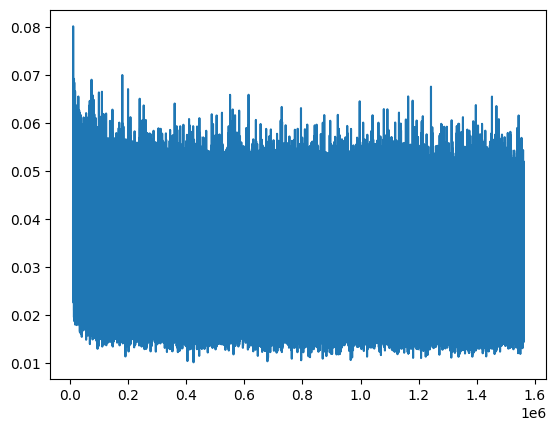

In [13]:
start = 10000
smooth = 1

x = np.arange(len(losses)/smooth)
y = torch.tensor(losses).view(smooth, -1).mean(0)
plt.plot(x[start:], y[start:])

# e_x = np.arange(0, (len(eval_losses)/smooth) * 100, 100)
# e_y = torch.tensor(eval_losses).view(smooth, -1).mean(0)
# plt.plot(e_x[int(start/100):], e_y[int(start/100):])

# plt.ylim(0, 0.5)
plt.show()

In [14]:
sum(losses[len(losses) - 100:]) / 100

0.029134641084820032

In [19]:
size = 1000
# training dataset
fens_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > 1000000 LIMIT {size}")
fens = fens_.fetchall()

# fig, ax = plt.subplots()

qmin = 0
qmax = 255

w = list(model.parameters())

w1 = w[0].detach().cpu()
w1_S = (w1.max() - w1.min()) / (qmax - qmin)
w1_Z = qmin - (w1.min() / w1_S)
q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

b1 = w[1].detach().cpu()
# q_b1 = (b1/w1_S + 0).clamp(-2147483648, 2147483647).round() # this clamping doesn't do anything :)

w2 = w[2].detach().cpu()
w2_S = (w2.max() - w2.min()) / (qmax - qmin)
w2_Z = qmin - (w2.min() / w2_S)
q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

b2 = w[3].detach().cpu()
# q_b2 = (b2/w2_S + 0).clamp(-2147483648, 2147483647).round()

w3 = w[4].detach().cpu()
w3_S = (w3.max() - w3.min()) / (qmax - qmin)
w3_Z = qmin - (w3.min() / w3_S)
q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

b3 = w[5].detach().cpu()
# q_b3 = (b3/w3_S + 0).clamp(-2147483648, 2147483647).round()

relu = nn.ReLU()
# L = []
# for i in w1.int():
#     L.append(i.item())
# print(L)
real = []
quant = []
# quants = 0
# quantz = 0
for i in range(1):
    fen = "rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1"
#     fen = fens[i][0]
    a = fen_to_bitboard(fen)
    
#     # real
    r = (a @ w1.T) + b1
#     r = relu(r)
#     r = (r @ w2.T) + b2
#     r = relu(r)
#     r = (r @ w3.T) + b3

#     # quantb
    q = (a @ (q_w1.T - w1_Z) * w1_S) + b1
    q = relu(q)
    q = (q @ (q_w2.T - w2_Z) * w2_S) + b2
    q = relu(q)
    q = (q @ (q_w3.T - w3_Z) * w3_S) + b3
    print(q.item())
    
    real.append(r[0][0].item())
    quant.append(q[0][0].item())
#     quants += -torch.min(q)+torch.max(q)
#     quantz += (torch.min(q)+torch.max(q))/2
# plt.scatter(real, quant)
# print(q_w2.T)
# plt.hist(w1.view(1, -1), 100);
# print(quants/1000)
# print(quantz/1000)

# print(r)
# print(q)
# print(q)
# print(w3_Z.item())
# for i in b3:
#     print(i.item(), end=", ")

0.47607165575027466


In [29]:
for row in range(q_w1.T.shape[0]):
    for col in range(q_w1.T.shape[1]):
        print(q_w1.T[row, col].item(), end=", ")
    print()

140.0, 119.0, 97.0, 123.0, 136.0, 116.0, 133.0, 129.0, 130.0, 124.0, 131.0, 127.0, 148.0, 133.0, 130.0, 135.0, 
126.0, 145.0, 135.0, 137.0, 121.0, 136.0, 124.0, 144.0, 116.0, 132.0, 132.0, 114.0, 144.0, 125.0, 138.0, 115.0, 
116.0, 143.0, 109.0, 124.0, 122.0, 122.0, 123.0, 123.0, 138.0, 121.0, 129.0, 142.0, 143.0, 127.0, 139.0, 140.0, 
131.0, 116.0, 125.0, 107.0, 143.0, 106.0, 119.0, 126.0, 145.0, 112.0, 132.0, 129.0, 135.0, 124.0, 121.0, 131.0, 
131.0, 111.0, 121.0, 127.0, 125.0, 142.0, 134.0, 137.0, 128.0, 123.0, 115.0, 128.0, 130.0, 108.0, 135.0, 127.0, 
136.0, 132.0, 126.0, 120.0, 126.0, 121.0, 136.0, 124.0, 125.0, 138.0, 138.0, 129.0, 129.0, 125.0, 144.0, 105.0, 
131.0, 115.0, 128.0, 122.0, 129.0, 134.0, 111.0, 125.0, 123.0, 128.0, 128.0, 115.0, 141.0, 140.0, 129.0, 115.0, 
138.0, 125.0, 114.0, 109.0, 114.0, 105.0, 133.0, 137.0, 127.0, 120.0, 143.0, 108.0, 129.0, 115.0, 124.0, 140.0, 
136.0, 130.0, 103.0, 112.0, 94.0, 108.0, 106.0, 110.0, 144.0, 127.0, 116.0, 107.0, 116.0, 126.0, 

In [30]:
for row in range(q_w1.T.shape[0]//4):
    for col in range(q_w1.T.shape[1]//4):
        print(q_w1.T[row*4:row*4+4, col*4:col*4+4])
#     print()

tensor([[140., 119.,  97., 123.],
        [126., 145., 135., 137.],
        [116., 143., 109., 124.],
        [131., 116., 125., 107.]])
tensor([[136., 116., 133., 129.],
        [121., 136., 124., 144.],
        [122., 122., 123., 123.],
        [143., 106., 119., 126.]])
tensor([[130., 124., 131., 127.],
        [116., 132., 132., 114.],
        [138., 121., 129., 142.],
        [145., 112., 132., 129.]])
tensor([[148., 133., 130., 135.],
        [144., 125., 138., 115.],
        [143., 127., 139., 140.],
        [135., 124., 121., 131.]])
tensor([[131., 111., 121., 127.],
        [136., 132., 126., 120.],
        [131., 115., 128., 122.],
        [138., 125., 114., 109.]])
tensor([[125., 142., 134., 137.],
        [126., 121., 136., 124.],
        [129., 134., 111., 125.],
        [114., 105., 133., 137.]])
tensor([[128., 123., 115., 128.],
        [125., 138., 138., 129.],
        [123., 128., 128., 115.],
        [127., 120., 143., 108.]])
tensor([[130., 108., 135., 127.],
       

In [11]:
def quant_evaluation(a):
    w = list(model.parameters())

    w1 = w[0].detach().cpu()
    w1_S = (w1.max() - w1.min()) / (qmax - qmin)
    w1_Z = qmin - (w1.min() / w1_S)
    q_w1 = (w1 / w1_S + w1_Z).clamp(qmin, qmax).round()

    b1 = w[1].detach().cpu()

    w2 = w[2].detach().cpu()
    w2_S = (w2.max() - w2.min()) / (qmax - qmin)
    w2_Z = qmin - (w2.min() / w2_S)
    q_w2 = (w2 / w2_S + w2_Z).clamp(qmin, qmax).round()

    b2 = w[3].detach().cpu()

    w3 = w[4].detach().cpu()
    w3_S = (w3.max() - w3.min()) / (qmax - qmin)
    w3_Z = qmin - (w3.min() / w3_S)
    q_w3 = (w3 / w3_S + w3_Z).clamp(qmin, qmax).round()

    b3 = w[5].detach().cpu()

#     # quantb
    q = (a @ (q_w1.T - w1_Z) * w1_S) + b1
    q = relu(q)
    q = (q @ (q_w2.T - w2_Z) * w2_S) + b2
    q = relu(q)
    q = (q @ (q_w3.T - w3_Z) * w3_S) + b3
    return q

In [109]:
print(b3)

tensor([0.5978])


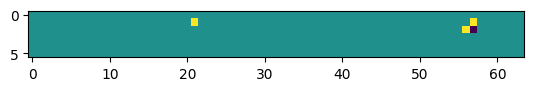

In [31]:
b = fen_to_bitboard("1rbqkbnr/pppppppp/n7/4N3/8/8/PPPPPPPP/RNBQKB1R w KQk - 4 3")
a = torch.tensor((0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, -1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 0, 0, 0, ))
plt.imshow(b.view(6, -1) - a.view(6, -1))


In [119]:
'{0:04b}'.format(15)

'1111'

In [42]:
temp = torch.zeros((3, 16))
tempington = torch.cat((q_w3, temp), dim=0)

In [47]:
compressed = []
bits = 8
for row in range(q_w2.T.shape[0]//4):
    for col in range(q_w2.T.shape[1]//4):
        L = list([int(i.item()) for i in q_w2.T[row*4:row*4+4, col*4:col*4+4].flatten()])
        for param in range(int(len(L)/bits)):
            string = ""
            for number in L[param*8:param*8+8]:
                string += '{0:08b}'.format(number)
        #     print(string)
            compressed.append(int(string, 2))
print(len(compressed))

32


In [115]:
abd = '{0:064b}'.format(100000)
len(abd)

64

In [25]:
size = 1000000

# evaluation dataset
eval_size = 1000
e_fen_ = cur.execute(f"SELECT fen FROM evaluations WHERE id > {size} LIMIT {eval_size}")
e_fen = e_fen_.fetchall()
tensors = [fen_to_bitboard(e_fen[i][0]) for i in range(eval_size)]
bits = torch.cat(tensors, dim=0)

evaluation_ = cur.execute(f"SELECT eval FROM evaluations WHERE id > {size} LIMIT {eval_size}")
evaluation = evaluation_.fetchall()
# temp = [((np.arctan(1/2 * evaluation[i][0]) + np.pi/2)/(np.pi)) for i in range(eval_size)]
temp = [transform(evaluation[i][0], e_fen[i][0]) for i in range(eval_size)]
evaluations = torch.tensor(temp)

model.eval()
losses = []

for i in range(eval_size):
    loss = loss_function(model(bits[i].to(device)).view(-1), evaluations[i].to(device).view(-1))
    losses.append(loss.item())
print(sum(losses) / len(losses))

0.04948471339278397


In [10]:
def evaluation(fen):
    model.eval()
    score  = model(fen_to_bitboard(fen).to(device))
    model.train()
    return score.item()

In [24]:
class Node():
    def __init__(self, fen, parent, color, move):
        self.fen = fen
        self.parent = parent
        self.children = None
        self.visits = 0
        self.prior = 0
        self.wins = 0
        self.color = color
        self.move = move

In [25]:
def minimax(board, depth, alpha, beta):
    moves = list(board.legal_moves)
    if depth == 1:
        tensors = []
        for m in moves:
            board.push(m)
            tensors.append(fen_to_bitboard(board.fen()).to(device))
            board.pop()
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        model.train()
        if board.turn == chess.WHITE:
            return torch.max(logits).item(), None
        else:
            return torch.min(logits).item(), None
    if board.turn == chess.WHITE:
        maxScore = -1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score > maxScore:
                maxScore = score
                best_move = m
            board.pop()
            alpha = max(alpha, score)
            if beta <= alpha:
                break
        if depth < 3:
            return maxScore, None
        if depth == 3:
            return maxScore, best_move
    else:
        minScore = 1000
        best_move = None
        for m in moves:
            board.push(m)
            score, _ = minimax(board, depth-1, alpha, beta)
            if score < minScore:
                minScore = score
                best_move = m
            board.pop()
            beta = min(beta, score)
            if beta <= alpha:
                break
        if depth < 3:
            return minScore, None
        if depth == 3:
            return minScore, best_move

In [19]:
def expand_node(node, color):
    board = chess.Board(node.fen)
    moves = list(board.legal_moves)
    nodes = []
    
    tensors = []

    for move in moves:
        board.push(move)
        n = Node(board.fen(), node, board.turn, move)
        nodes.append(n)
        tensors.append(fen_to_bitboard(n.fen).to(device))
        board.pop()

    node.children = nodes
    
    if len(node.children) > 0:
        model.eval()
        logits = model(torch.cat(tensors, dim=0))
        
        if node.color == False:
            for i, child in enumerate(node.children):
                child.prior = (1 - logits[i].item())
            return float(1 - sum(logits) / len(logits))
        else:
            for i, child in enumerate(node.children):
                child.prior = (logits[i].item())
            return float(sum(logits) / len(logits))
        model.train()

def select_child(node):
    best_node = None
    
    best = -np.inf
    for child in node.children:
        if child.visits > 0:
            val = child.wins / child.visits + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits))
        else:
            val = child.prior + np.sqrt(2) * np.sqrt(np.log(node.visits) / (child.visits + 1))
#         print(f"{child.move} {child.visits} {child.prior:.3f} {child.wins:.3f} {val:.4f} {node.visits}")
        if val > best:
            best = val
            best_node = child
    
#     print(best_node.move)
    return best_node

def backpropagate(node, score, color):
    while node is not None:
        node.visits += 1
        if color == node.color:
            node.wins += score
        else:
            node.wins += (1 - score)
        node = node.parent

def search(board):
    root = Node(board.fen(), None, board.turn, None)

    for _ in range(1000):
        # Selection and expansion
        current = root
        while current.children is not None:
            current = select_child(current)
#         print()

        if current.visits == 0:
            # If the node has not been visited yet, expand it
            score = expand_node(current, current.color)

        # Simulation
        score = current.prior

        # Backpropagation
        backpropagate(current, score, current.color)

    # Choose the best move based on visits
    best_visits = -1
    best_move = ""

    for node in root.children:
        print(f"{node.move} {node.visits} {node.prior:.3f} {node.wins:.3f} {(node.wins/(node.visits)):.4f}")
        if node.visits > best_visits:
            best_visits = node.visits
            best_move = node.move
    
    return best_move

In [50]:
fen = "rnb1kbnr/pp1ppppp/2p5/7Q/3qP1PP/1PNB1P2/P1PB4/1KNR3R w kq - 5 17"
board = chess.Board(fen)
print(minimax(board, 3, -1000000, 1000000))
# search(board)

(0.8731439113616943, Move.from_uci('c1e2'))


In [13]:
# white
fen = "1rb4r/pp1pkp1p/n1p1pn1b/7p/q3P2Q/P4N2/1P1N1PP1/RBB1K1R1 w Q - 12 21"
board = chess.Board(fen)
moves = list(board.legal_moves)

scores = []
best_score = -1000
best_move = ""
for m in moves:
    board.push(m)
    score = evaluation(board.fen())
    scores.append(score)
    print(str(score) + " " + str(m))
    if score > best_score:
        best_score = score
        best_move = m
    board.pop()
print(best_move)
print(sum(scores) / len(scores))

0.7548853754997253 h4f6
0.48256605863571167 h4h5
0.362621545791626 h4g5
0.38108348846435547 h4g4
0.4056733250617981 h4f4
0.362155556678772 h4h3
0.37020647525787354 h4g3
0.2674683928489685 h4h2
0.35266613960266113 h4h1
0.3881228566169739 f3g5
0.42560815811157227 f3e5
0.4721144437789917 f3d4
0.3565548062324524 f3h2
0.4224214255809784 d2c4
0.4438764750957489 d2b3
0.35755419731140137 d2f1
0.4420880377292633 g1h1
0.4407748579978943 g1f1
0.32143816351890564 e1e2
0.305719256401062 e1f1
0.3617178797721863 b1d3
0.4159448444843292 b1c2
0.30919039249420166 b1a2
0.3803477883338928 a1a2
0.4002089500427246 e4e5
0.3896201550960541 g2g3
0.4014032781124115 b2b3
0.40192025899887085 g2g4
0.397177129983902 b2b4
h4f6
0.39907343839776926


In [15]:
# black
fen = "1rb4r/pp1pkp1p/n1p1pn1b/7p/q3P2Q/P4N2/1P1N1PP1/RBB1K1R1 w Q - 12 21"
# board = chess.Board(fen)
# moves = list(board.legal_moves)
print(evaluation(fen))

# scores = []
# best_score = 1000
# best_move = ""
# for m in moves:
#     board.push(m)
#     score = evaluation(board.fen())
#     scores.append(score)
#     print(f"{score} {m}")
#     if score < best_score:
#         best_score = score
#         best_move = m
#     board.pop()
# print(best_move)
# print(1 - sum(scores) / len(scores))

0.5120874643325806


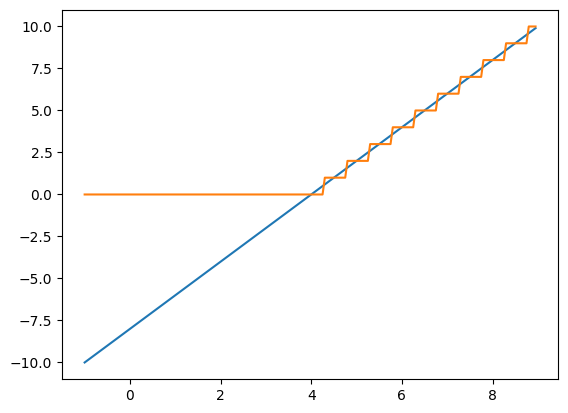

In [62]:
x = np.arange(-1, 9, .05)
y = np.arange(-10, 10, .1)
plt.plot(x, y)
y = [np.round(max(0, i)) for i in y]
plt.plot(x, y)

In [54]:
a = torch.rand((2, 16))
b = torch.rand((16, 4))
# (1, 16) @ (16, 4) = (1, 4)

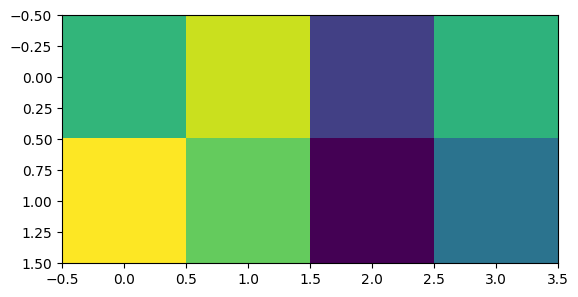

In [55]:
plt.imshow(a @ b)

In [54]:
for r in b:
    for c in r:
        print(c.item(), end="f, ")


0.09802323579788208f, 0.09665560722351074f, 0.5750908255577087f, 0.7510685920715332f, 0.9153562784194946f, 0.4323890209197998f, 0.5761985778808594f, 0.5010663866996765f, 0.10167789459228516f, 0.07291549444198608f, 0.2576272487640381f, 0.6675180792808533f, 0.26626837253570557f, 0.5234975218772888f, 0.9565550088882446f, 0.22243601083755493f, 0.3465682864189148f, 0.815252959728241f, 0.015560150146484375f, 0.8576486110687256f, 0.3054353594779968f, 0.302367627620697f, 0.5751824378967285f, 0.5659737586975098f, 0.5978508591651917f, 0.8426461219787598f, 0.6160740852355957f, 0.39441657066345215f, 0.6221723556518555f, 0.22485774755477905f, 0.4202009439468384f, 0.48693448305130005f, 0.1583150029182434f, 0.5939502716064453f, 0.9476490616798401f, 0.18271297216415405f, 0.8026080131530762f, 0.5528708696365356f, 0.643247127532959f, 0.9439643025398254f, 0.04886424541473389f, 0.9725059270858765f, 0.539108157157898f, 0.6467350721359253f, 0.32848089933395386f, 0.9851852655410767f, 0.06277245283126831f, 0.

In [49]:
for r in b:
    print("{", end="")
    for c in r:
        print(c.item(), end=", ")
    print("}, ", end="")

{6, 6, 5, 6, 6, 6, 7, 1, 3, 7, 5, 0, 4, 0, 6, 8, }, {4, 8, 3, 9, 0, 3, 9, 9, 2, 9, 7, 8, 3, 6, 1, 5, }, {7, 8, 5, 7, 7, 3, 4, 5, 5, 1, 8, 2, 6, 1, 5, 1, }, {7, 8, 3, 4, 3, 5, 5, 8, 9, 7, 4, 4, 0, 6, 2, 1, }, {7, 6, 4, 9, 1, 5, 5, 9, 3, 9, 8, 8, 2, 2, 9, 2, }, {3, 4, 1, 8, 9, 2, 9, 1, 2, 6, 7, 6, 1, 9, 3, 9, }, {7, 9, 2, 9, 3, 7, 8, 9, 1, 2, 1, 6, 6, 0, 2, 4, }, {9, 4, 1, 3, 5, 8, 8, 0, 3, 0, 2, 4, 2, 8, 4, 8, }, {8, 5, 9, 6, 9, 6, 9, 2, 5, 1, 7, 7, 8, 2, 1, 4, }, {6, 8, 6, 5, 1, 7, 4, 8, 6, 8, 8, 8, 8, 9, 3, 3, }, {8, 1, 6, 5, 4, 0, 4, 3, 0, 3, 4, 9, 6, 3, 7, 3, }, {9, 8, 5, 7, 6, 1, 6, 8, 8, 8, 6, 9, 4, 1, 1, 8, }, {2, 4, 5, 4, 6, 7, 3, 6, 9, 4, 6, 0, 9, 2, 4, 8, }, {7, 5, 5, 1, 5, 2, 4, 7, 4, 8, 3, 3, 7, 8, 4, 3, }, {5, 2, 1, 0, 4, 4, 3, 3, 1, 0, 4, 5, 1, 5, 1, 6, }, {2, 0, 5, 4, 5, 2, 6, 9, 5, 6, 0, 5, 0, 2, 8, 6, }, 

In [49]:
a @ b

tensor([[0.2434, 0.5760, 0.7501, 1.0267],
        [0.6287, 0.9836, 1.5447, 1.7224],
        [0.2930, 0.5350, 0.4950, 0.9322],
        [0.6117, 0.8212, 0.8646, 1.1010]])

In [32]:
print(a.shape)
print(b.shape)
for row in range(1):
    for col in range(1):
        c = torch.zeros((4, 4))
        for i in range(4):
            print(a[row*4:row*4+4, i*4:i*4+4])
            print(b[i*4:i*4+4, col*4:col*4+4])
            c += a[row*4:row*4+4, i*4:i*4+4] @ b[i*4:i*4+4, col*4:col*4+4]
# torch.max(c - (a @ b))

torch.Size([4, 16])
torch.Size([16, 4])
tensor([[ 1.6764, -0.5967,  0.7432, -1.6759],
        [ 0.0644,  1.0129, -0.2032, -1.5021],
        [-0.5312,  0.2616,  1.5954, -0.7782],
        [ 0.3293, -0.7948, -0.1705,  0.1084]])
tensor([[-1.4335, -1.5384,  0.1661,  0.0183],
        [-0.0152, -0.6636, -1.2570,  0.1718],
        [-2.0307,  0.0535,  0.7373,  0.5048],
        [-1.3098, -0.2302,  1.0360,  1.1701]])
tensor([[-2.0151,  0.8615,  0.1116,  1.0290],
        [-1.5374,  1.5765, -0.3632, -0.3616],
        [-1.6024, -0.9151,  0.1957, -0.5774],
        [ 0.1745,  1.4125, -0.5483, -0.4575]])
tensor([[ 0.1910,  0.1956, -0.4993,  0.6733],
        [ 0.3484,  0.3087,  0.8932, -0.3334],
        [-0.5421,  2.3386,  1.7344,  0.5666],
        [ 1.3201,  1.0652, -0.9892, -0.6864]])
tensor([[ 1.3639, -0.3597, -1.3043, -0.4681],
        [-0.5600,  0.2358, -0.3419, -0.7324],
        [ 1.5405, -0.6913,  0.2770,  0.4174],
        [ 1.0426, -0.8042,  0.3397, -0.2514]])
tensor([[ 1.6215, -0.9752,  0.4873,

In [31]:
print(a@b)

tensor([[ 1.7558, -2.2515, -1.6547, -5.1124],
        [ 0.9204, -1.1286, -3.7277, -7.7244],
        [-1.2007, -6.4726,  2.8340,  2.0231],
        [ 1.2364, -3.9532,  3.1513,  3.8164]])


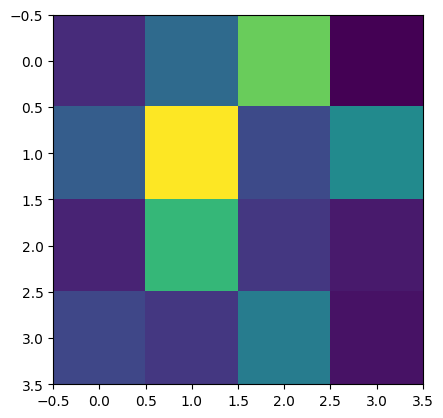

In [9]:
plt.imshow(a[0*4:0+4, 1*4:1*4+4])

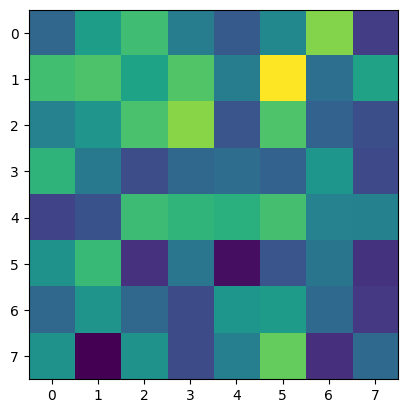

In [6]:
plt.imshow(a)